In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from censai import RIMUnet, PhysicalModel
from censai.data import NISGenerator
import os

In [21]:
kappa_checkpoints_dir = os.path.join(os.getenv("HOME"), "scratch/Censai/models/UnetRIM_21-06-02_15-11-15/kappa_checkpoints/")
source_checkpoints_dir = os.path.join(os.getenv("HOME"), "scratch/Censai/models/UnetRIM_21-06-02_15-11-15/source_checkpoints/")


phys = PhysicalModel(
    pixels=64,
    src_pixels=3,
    image_fov=7.68,
    kappa_fov=7.68,
    method="conv2d",
    noise_rms=1e-3,
    kappalog=True,
)

rim = RIMUnet(phys, 50, 16, 64, adam=True, kappalog=True, normalize=False,
                  **{"source": {"strides": 2},
                     "kappa": {"strides": 2}})

source_ckpt = tf.train.Checkpoint(net=rim.source_model)
source_checkpoint_manager = tf.train.CheckpointManager(source_ckpt, source_checkpoints_dir, max_to_keep=3)
kappa_ckpt = tf.train.Checkpoint(net=rim.kappa_model)
kappa_checkpoint_manager = tf.train.CheckpointManager(kappa_ckpt, kappa_checkpoints_dir, max_to_keep=3)

kappa_checkpoint_manager.checkpoint.restore(kappa_checkpoint_manager.latest_checkpoint)
source_checkpoint_manager.checkpoint.restore(source_checkpoint_manager.latest_checkpoint)

In [22]:
gen = NISGenerator(1000, batch_size=50, pixels=64)

In [23]:
lens, source, kap = gen.generate_batch_rim()

In [43]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
source_pred, kap_pred, cost = rim.forward_pass(lens) 

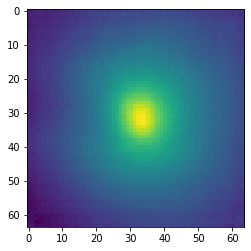

In [49]:
plt.imshow(kap_pred[-1][2, ..., 0])

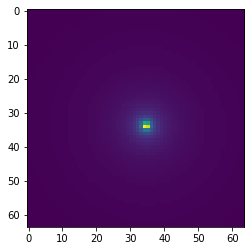

In [51]:
plt.imshow(kap[30, ..., 0])